In [1]:
from utils import create_grid, smooth_proba, classify
from feature_calculator import FeatureCalculator
from feature_calculator import OfParams
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pims

# folder where the data is saved
rec_folder = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/")

# name of the recording
clip_name = "padel_tennis_neon_03-2ded8f56"

# load video object
vid = pims.Video(str(rec_folder / clip_name / "Neon Sensor Module v1 ps1.mp4"))

deprecated pixel format used, make sure you did set range correctly


<font size = 5>**(1) Calculate optical flow fields for each frame** <br><br>
<font size = 3>Compute optical flow fields using the the Lucas-Kanade method as implemented in OpenCV, on 4x4 grid points<br>
Optical flow vectors are computed separately for left and right video frames and then concatenated.

In [2]:
# define optical flow parameters
of_params = OfParams(n_layers=5, layer_interval=7, average=False, img_shape=(64, 64), grid_size=4, step_size=7, window_size=15, stop_steps=3)

# define grid for optical flow calculation
grid = create_grid(of_params.img_shape, of_params.grid_size + 2)

# initialize feature calculator object
feature_calculator = FeatureCalculator(vid, of_params, grid)

# calculate optical flow for each frame (saves only y component of optical flow)
feature_calculator.calculate_optical_flow()

<font size = 3>Plot mean optical flow for a given time interval

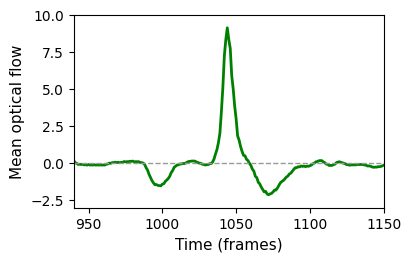

In [115]:
fig, ax = plt.subplots(figsize=(4, 2.5))

# compute and plot mean optical flow across all grid points
mean_optical_flow = np.mean(feature_calculator.of_array, axis=1)
ax.plot(mean_optical_flow, color='green', linewidth=2)

# Set axis labels and limits
ax.set_xlabel('Time (frames)', fontsize=11)
ax.set_ylabel('Mean optical flow', fontsize=11)
ax.set_xlim(940, 1150)
ax.set_ylim(-3, 10)

# Add horizontal line at y=0
ax.axhline(0, color=[.6, .6, .6], linestyle='--', linewidth=1)

<font size = 5>**(2) Create feature vector** <br><br>
<font size = 3>A feature vector is constructed containing the optical flow associated with the current,<br> 
as well as preceding as well as subsequent frames. More specifically, the optical flow vectors<br> 
across multiple points in time (in the following: “layers”) are concatenated,<br>
with a given number of layers (n_layers = 5) and a temporal interval between the layers<br> 
(layer_interval = 7 frames, corresponding to a time difference of 35 ms).<br><br>

The number of features is given by: <b>n_layers</b> (5) <b>x n_grid_points</b> (16) <b>x 2</b> (left + right) <b> = 160 features</b>

In [4]:
n_layers = 5
layer_interval = 7

feature_calculator.concatenate_optical_flow(n_layers, layer_interval)

print("Number of features: {}".format(feature_calculator.feature_array.shape[1]))

Number of features: 160


<font size = 5>**(3) Feed into classifier** <br><br>
<font size = 3>The feature vectors are submitted to the pre-trained XGBoost classifier to generate a time-series of class probabilities.<br>
The three classes are: (1) Background (2) Blink onset (eyelid closing) and (3) Blink offset (eyelid reopening)<br><br>
<font size = 3>Load trained XGBoost classifier:

In [5]:
import joblib
# path to trained classifier
clf_path = "/users/tom/git/neon_blink_detection/weights/xgb.sav"
# load pre-trained classifier
clf = joblib.load(clf_path)
clf

/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='approx', use_label_encoder=False,
              validate_parameters=1, ...)

<font size = 3>Obtain frame-wise class probabilities:

In [6]:
probas = clf.predict_proba(feature_calculator.feature_array)

<font size = 5>**(4) Temporal smoothing** <br><br>
<font size = 3>Runing average with kernel size of 11 frames.

In [7]:
kernel_size = 11
smoothed_proba = smooth_proba(probas, kernel_size)

<font size = 3>Plot blink onset and offset probabilities before and after smoothing. <br>
Dashed line shows onset/offset threshold for discretization (see below).

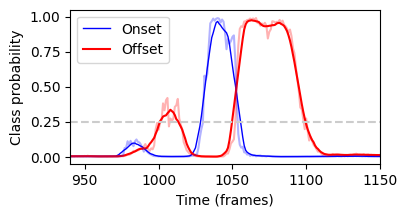

In [8]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))

ax.plot(smoothed_proba[:, 1], color="blue", lw=1)
ax.plot(smoothed_proba[:, 2], color="red")
ax.plot(probas[:, 1], color="blue", alpha=0.3)
ax.plot(probas[:, 2], color="red", alpha=0.3)

# horizontal line at 0.25
ax.axhline(0.25, color=[.8, .8, .8], linestyle="--")

ax.set_xlabel("Time (frames)")
ax.set_ylabel("Class probability")
ax.set_xlim(940, 1150)
ax.legend(["Onset",  "Offset"])

<font size = 5>**(5) Discretization** <br><br>
<font size = 3>Turns class probabilities into discrete class predictions.

In [9]:
prediction = classify(smoothed_proba, onset_threshold=0.25, offset_threshold=0.25)

<font size = 5>**(6) Conversion to events** <br><br>
<font size = 3>Consecutive frames classified as blink onsets or blink offsets are compiled into blink onset or blink offset events,<br>
each defined by its type (onset or offset) as well as a start and end time. The obtained event series is submitted to a post-processing<br> 
procedure that exploits the stereotypical sequence of eyelid closing and reopening inherent to eye blinks,<br>
as well as other temporal characteristics (total blink duration as well as the temporal lag between blink onset and offset).

In [10]:
# import EventArray class and event filter functions
from event_array import EventArray, filter_wrong_sequence, filter_short_events

<font size = 4>**(6.1) Filter wrong sequence**<br><br>
<font size = 3>Remove events where the order of events is incorrect, e.g. blink offsets preceding onsets or isolated offset/onset events

In [11]:
# if gap between onset and offset event is longer than 30 ms, discard the event
max_gap_duration_s = 0.03
timestamps = np.arange(0, len(prediction)) / 200

# create event array
event_array_pd = EventArray.from_samples(timestamps, prediction)

# filter wrong sequence (e.g. onset without offset) and events with long gap
blink_array_pd = filter_wrong_sequence(event_array_pd, max_gap_duration_s)

<font size = 4>**(6.2) Filter short events**<br><br>
<font size = 3>Remove blinks that are shorter than 100 ms.

In [63]:
# define minimum blink duration
min_len_s = 0.1
# define label for blink events
blink_label = 3

# filter short blinks
blink_array_pd = filter_short_events(blink_array_pd, min_len_s, blink_label)

# get blink events
blink_events = blink_array_pd.blink_events

print("Number of blinks: {}".format(len(blink_events)))

Number of blinks: 62


<font size = 5>**Visualize predicted blinks**

Text(0.5, 1.0, 'Example blink #2')

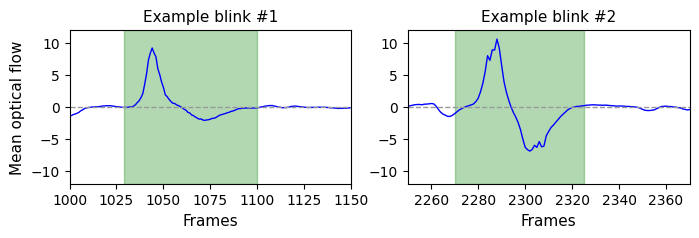

In [105]:
mean_of = np.mean(feature_calculator.of_array, axis=1)

f, ax = plt.subplots(1, 2, figsize=(8, 2))

ax[0].plot(mean_of, color="blue", lw=1)
ax[0].axhline(0, color=[.6, .6, .6], linestyle="--", linewidth=1)

# plot blink events as horizontal lines
for iblink in range(len(blink_events)):
    start = blink_events[iblink].start_time * 200
    end = blink_events[iblink].end_time * 200
    ax[0].axvspan(start, end, color="green", alpha=0.3)

ax[0].set_xlim(1000, 1150)
ax[0].set_ylim(-12, 12)
ax[0].set_xlabel("Frames", fontsize=11)
ax[0].set_ylabel("Mean optical flow", fontsize=11)
ax[0].set_title("Example blink #1", fontsize=11)

ax[1].plot(mean_of, color="blue", lw=1, label='_Hidden label')
ax[1].axhline(0, color=[.6, .6, .6], linestyle="--", linewidth=1)

# plot blink events as horizontal lines
for iblink in range(len(blink_events)):
    start = blink_events[iblink].start_time * 200
    end = blink_events[iblink].end_time * 200
    ax[1].axvspan(start, end, color="green", alpha=0.3)

ax[1].set_xlim(2250, 2370)
ax[1].set_ylim(-12, 12)
ax[1].set_xlabel("Frames", fontsize=11)
ax[1].set_title("Example blink #2", fontsize=11)


<font size = 4>**Plot mean optical flow for all blinks, aligned to blink onset**

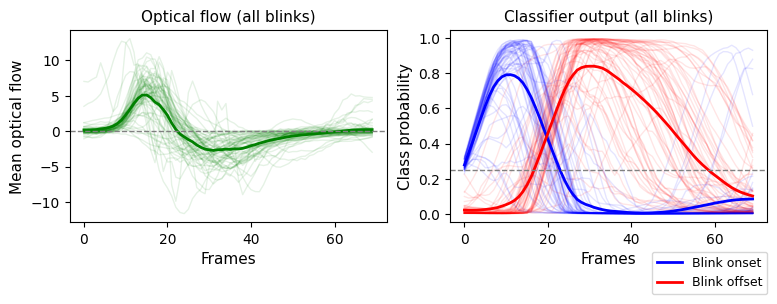

In [111]:
f, ax = plt.subplots(1, 2, figsize=(9, 2.5))

# plot all blinks from onset to onset + 70 frames into one plot
of_all_blinks = np.zeros((len(blink_events), 70))
for iblink in range(len(blink_events)):
    start = int(blink_events[iblink].start_time * 200)
    ax[0].plot(mean_of[start:start+70], color="green", lw=1, alpha=0.1)
    of_all_blinks[iblink, :] = mean_of[start:start+70]

# plot mean of all blinks
ax[0].plot(np.mean(of_all_blinks, axis=0), color="green", lw=2)

# horizontal line at 0
ax[0].axhline(0, color=[.5, .5, .5], linestyle="--", linewidth=1)

ax[0].set_xlabel("Frames", fontsize=11)
ax[0].set_ylabel("Mean optical flow", fontsize=11)
ax[0].set_title("Optical flow (all blinks)", fontsize=11)

proba_all_blinks = np.zeros((len(blink_events), 70, 2))

for iblink in range(len(blink_events)):
    start = int(blink_events[iblink].start_time * 200)
    ax[1].plot(smoothed_proba[start:start+70, 1], color="blue", lw=1, alpha=0.1)
    ax[1].plot(smoothed_proba[start:start+70, 2], color="red", lw=1, alpha=0.1)
    proba_all_blinks[iblink, :, :] = smoothed_proba[start:start+70, 1:]

# plot mean of all blinks
ons, = ax[1].plot(np.mean(proba_all_blinks[:, :, 0], axis=0), color="blue", lw=2, label="Blink onset")
off, = ax[1].plot(np.mean(proba_all_blinks[:, :, 1], axis=0), color="red", lw=2, label="Blink offset")

# horizontal line at 0.25
ax[1].axhline(0.25, color=[.5, .5, .5], linestyle="--", linewidth=1)

ax[1].set_xlabel("Frames", fontsize=11)
ax[1].set_ylabel("Class probability", fontsize=11)
ax[1].set_title("Classifier output (all blinks)", fontsize=11)
ax[1].legend(handles=[ons, off], bbox_to_anchor=(1.02, -0.12), fontsize=9)